# Training a Convolutional Neural Network (CNN)
*The code in this notebook can take some minutes to fully execute. Do not worry if some cells are still executing after four to five minutes, it is expected for some training processes to take even longer.*

## Introduction to the Case Study

**Business Context.** You are a computer security advisor with knowledge in Deep Learning from AI Integrated Services (fictitious name). This New York-based company provides Artificial Intelligence services and is looking for talent for one of its projects, real-time digits recognition with high accuracy.

**Business Problem.** The current techniques used to identify hand-written digits are based on the expert view and Feed-Forward Neural Netoworks, having an acceptable performance, but not the desired one (above 95%). The company wants to improve the current model performance by including more up-to-date algorithmic solutions on the Deep Learning space.

**Data context.** The data to be processed was obtained from a large number of digital contracts, currently available in the following files: `train-images`, `train-labels`, `test-images` and `test-labels`.

## Importing the packages for data analysis

We will use three main packages: `pandas`, `numpy`, and `matplotlib`. Let's import these packages using the `import` keyword. We will rename `pandas` to `pd`, `numpy` to `np`, and `matplotlib` to `plt`, using the `as` keyword.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import time

from MNIST import MNIST_Reader
from DataLoader import MNIST_DataLoader

We will read a series of grayscale digital image files representing the digits of digital contracts, separated into training and testing data. Each data set consists of 28x28 digit grayscale images, stored as serialized `numpy` arrays. We will use the `MNIST` (specifically the `MNIST_Reader`) package provided to read and load the images.

Let's now instantiate the class and read the images of the digit 7:

In [2]:
training_set, testing_set = MNIST_Reader().load_images_from_digit(digit=7)

Let's check the size of the arrays containing the images:

In [3]:
print(training_set.shape, testing_set.shape)

(28, 28, 3132) (28, 28, 3133)


As we can see, we have 3132 training images and 313 testing images, all of them with a spatial resolution (size) of 28x28 pixels. Let's now look at three randomly selected images:

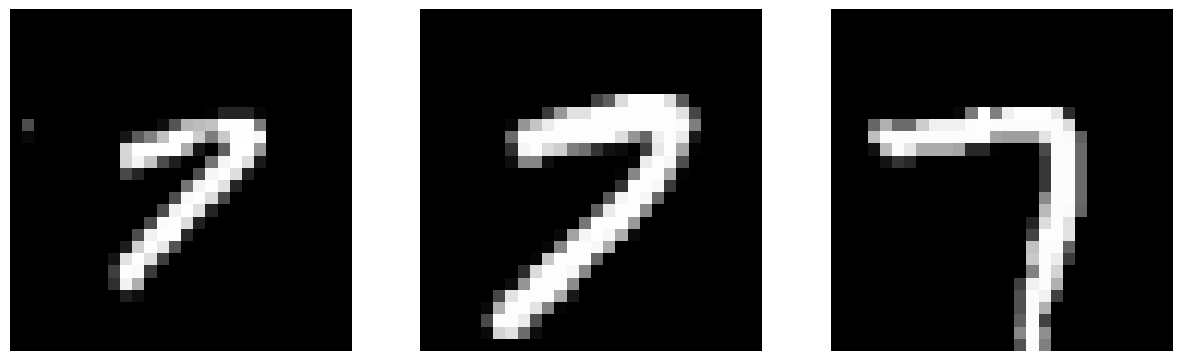

In [4]:
# Plot three images

image_indices = [1, 100, 1000]                       # Hand-picked image indices
fig, axes = plt.subplots(1,3,figsize=(15,100))       # Plottig three images in one row
plt.rcParams['image.cmap'] = 'gray'                  # Param defining grayscale images to be plotted
for idx,image_idx in enumerate(image_indices):       # Plotting the three images selected
    axes[idx].imshow(training_set[:,:,image_idx])
    axes[idx].axis('off')
plt.show()                                           # Showing the images in the plot

# Convolutional Neural Networks

### Building our Neural Network architecture from scratch

To build a Convolutional Neural Network, we first need to see how to append multiple layers into formal neural blocks. So far, we have used the following Multi-Layer Perceptron architecture to build a Feed-Forward Neural Network:

In [5]:
class MLP_Classifier(nn.Module):
    def __init__(self):
        super(MLP_Casslfier, self).__init__()             # This avoids re-implementing initialization from nn.Module
        self.layer_1 = nn.Linear(28*28, 256, bias=True)   # Creating the first layer of the neural network
        self.layer_2 = nn.Linear(256, 10, bias=True)      # Creating the second layer of the neural network
        self.relu_function  = nn.ReLU()                   # Creating the ReLU function
    
    def forward(self, x):                                 # Forward method to propagate information
        x = self.layer_1(x)
        x = self.relu_function(x)
        output = self.layer_2(x)
        return output

In the architecture shown above, we are stacking a Linear layer with a ReLU function having 784 and 256 neurons, respectively, followed by a Linear output layer with 10 neurons in the output. The `.forward()` function is the one stacking all layers together in a sequential order. Nevertheless, this is not the only way to implement stacked layers in a neural structure. We can use the `Sequential` class to formally defined steps that will be executed in a sequential order:

In [6]:
class MLP_Classifier_Seq(nn.Module):
    def __init__(self):
        super(MLP_Classifier_Seq, self).__init__()
        
        self.seq_block = nn.Sequential(
            nn.Flatten(),                         # Flattening the input from a bicimensional representation to a unidimensional one
            nn.Linear(28*28, 256, bias=True),     # Creating the first layer of the neural network
            nn.ReLU(inplace=True),                # Defining the ReLU function to be executed sequentially
            nn.Linear(256,10, bias=True),         # Creating the second layer of the neural network
        )

    def forward(self, x):                         # Forward method to propagate information
        return self.seq_block(x)

As you can see from the above, stipulating layers with `Sequential`  is not only much easier to do, but much easier to follow and interpret. We can clearly see that a linear step, followed by a ReLU function and then a linear step are done to finally move the information from 784 input neurons to 10 output ones. This architecture with sequential steps is the one that we will use to stipulate convolutional, pooling, normalization and dropour layers from now on.

Let's export the complete dataset with images from all digits from 0 to 9. To do so, we will use the `MNIST_DataLoader` class within the `DataLoader` package. This class consumes data from our MNIST folder and structures it for proper consumption. We just need to define the digits to be imported (`labels_input`) and the batch size (`batch_size`):

In [7]:
labels_input = [i for i in range(0,10)]    # The images from this digit labels will be imported
batch_size = 64                            # Size of the batch used to partition the data

# Importing the images from all digits mapped in labels_input
data_loader = MNIST_DataLoader(labels_input = labels_input)
training_set, testing_set, training_labels, testing_labels = data_loader.get_images()

Now, let's split the data into batches of 64 observations:

In [8]:
# Splitting the training and testing data into batches of 64 observaciones with their labels
training_set_batches, training_labels_batches = data_loader.split_batches(training_set, training_labels, batch_size = batch_size)
testing_set_batches, testing_labels_batches = data_loader.split_batches(testing_set, testing_labels, batch_size = batch_size)

# Iterating over the first five random batches of the training dataset
for idx, array in enumerate(training_set_batches[:5]):
        print(array.shape)                                        # Showing the shape of the training set per batch
        print(training_labels_batches[idx].shape, end='\n\n')     # Showing the shape of the labels array per batch

(64, 1, 28, 28)
(64,)

(64, 1, 28, 28)
(64,)

(64, 1, 28, 28)
(64,)

(64, 1, 28, 28)
(64,)

(64, 1, 28, 28)
(64,)



Most of the batches will have 64 samples in their training/testing set and 64 target values in the labels' array. There are few batches that will have 63 samples due to the fact that the number of training samples is not a multiple of 64.

### Building the training and testing methods

Let's start by defining the training method, which will receive the trainig data, the classifier object, the number of training iterations and the loss function to be evaluated:

In [9]:
def train(X_train, y_train, classifier, optimizer,
          epochs = 25,
          loss_function = nn.CrossEntropyLoss(), 
          verbose = True):

    """
    Training function.
    Inputs:
        - classifier: base classifier object to be used
        - optimizer: optimizer to be used to calculate the gradients
        - epochs: number of trainig iterations
        - loss_function: loss function object to be used to calculate training error
        - X_train: training samples formatted in batches
        - y_train: training labels formatted in batches
        - verbose: binary label to determine whether to print extra info or not
    Outputs:
        - None
    """

    classifier.train()                                            # Setting the model to train
    loss_list = []                                                # Defining the loss list to store the loss per epoch

    # Iterating over each epoch
    for epoch in range(epochs):
        running_loss = 0.0

        # Iterating over each minibatch
        for idx, array in enumerate(X_train):
            target = torch.tensor(y_train[idx]).long()            # Parsing the labels to a tensor
            data = torch.tensor(array).float()                    # Parsing the data to a Float tensor
            output = classifier(data)                             # Calculating the output of the network for a given batch
            computed_loss = loss_function(output, target)         # Calculating the loss for a given minibatch
            computed_loss.backward()                              # Executing the backpropagation
            optimizer.step()                                      # Updating the weights through SGD one step ahead
            optimizer.zero_grad()                                 # Setting gradients to zero after the step above
            running_loss += computed_loss.item()                  # Keep track of cummulative loss of each minibatch
        loss_list.append(running_loss/len(X_train))               # Appending the loss per epoch in a list

        if verbose:
            print("Epoch: {}, Train loss: {}".format(epoch+1,     # Printing the epoch iteration id and the loss per epoch
                                                    running_loss/len(X_train)))

    # Plotting the loss per epoch during training
    plt.plot([i for i in range(1,epochs+1)], loss_list)
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Training Loss - Learning rate {}".format(optimizer.defaults['lr']))
    plt.show()

In the training function defined above, we are iterating over each of the batches and moving the updates of the weights according to the gradients calculated. Every time we move, we update the weights and register the compounded loss. This will happen in each of the training iterations until reaching the ixed number of iterations defined in `epoch`.

Now that we know how training can be programmatically defined, let's see how to test the model:

In [10]:
def test(X_test, y_test, classifier, 
         loss_function = nn.CrossEntropyLoss(),
         batch_size = 64):
    """
    Training function.
    Inputs:
        - classifier: base classifier object to be used
        - loss_function: loss function object to be used to calculate testing error
        - X_test: testing samples formatted in batches
        - y_test: testing labels formatted in batches
        - batch_size: size of the batch
    Outputs:
        - final_loss: final loss after testing with all given observations
        - final_accuracy: final accuracy after testing with all given observations
    """
    
    classifier.eval()                                               # Setting the model to be tested
    accuracy = 0.0                                                  # Accuracy accumulator
    computed_loss = 0.0                                             # Loss accumulator

    with torch.no_grad():                                           # Telling PyTorch that we don't need gradients when testing
        for idx, array in enumerate(X_test):
            target = torch.tensor(y_test[idx]).long()               # Parsing the labels to a tensor
            data = torch.tensor(array).float()                      # Parsing the data to a Float tensor
            output = classifier(data)                               # Calculating the output of the network for a given batch
            _, preds = output.max(dim=1)                            # Getting the predicted label

            # Get loss and accuracy
            computed_loss += loss_function(output, target)          # Keep track of the cummulative loss of each batch
            accuracy += torch.sum(preds == target)                  # Calculating the total number of coinciding elements
        
        final_loss = computed_loss.item()/(len(X_test)*batch_size)  # Final loss calculation
        final_accuracy = accuracy*100.0/(len(X_test)*batch_size)    # Final accuracy calculation
        print("Test loss: {}, test accuracy: {}".format(            # Printing the final performance (loss & accuracy)
                    final_loss, final_accuracy))

    return final_loss, final_accuracy

As in training, in testing we iterate over each of the testing batches. However, this time we are not updating any weights nor executing training iterations. We are simply measuring the loss per batch and calculating the global loss of the classifier with all testing samples. We are also calculating the accuracy of the model, which is defined as how many samples is the model getting right from the total samples we gave in the testing.

### Training a Feed-Forward Neural Network

Before training a Convolutional Neural Network, let's start by training the Multi-Layer Perceptron defined a couple of cells above:

Epoch: 1, Train loss: 2.2659026417396726
Epoch: 2, Train loss: 2.1681972805625085
Epoch: 3, Train loss: 2.054852269605787
Epoch: 4, Train loss: 1.9193983072919378
Epoch: 5, Train loss: 1.7655433896762223
Epoch: 6, Train loss: 1.6044663988959307
Epoch: 7, Train loss: 1.4484291094452588
Epoch: 8, Train loss: 1.306459957094335
Epoch: 9, Train loss: 1.1828580166993619
Epoch: 10, Train loss: 1.0780692443664648
Epoch: 11, Train loss: 0.9903522079179028
Epoch: 12, Train loss: 0.9171422563636227
Epoch: 13, Train loss: 0.8558286588583419
Epoch: 14, Train loss: 0.8041316959649515
Epoch: 15, Train loss: 0.7601785309024965
Epoch: 16, Train loss: 0.7224689201632543
Epoch: 17, Train loss: 0.689826901660545
Epoch: 18, Train loss: 0.6613335782276796
Epoch: 19, Train loss: 0.6362674996924045
Epoch: 20, Train loss: 0.6140559652466764
Epoch: 21, Train loss: 0.5942470877409489
Epoch: 22, Train loss: 0.5764761403171238
Epoch: 23, Train loss: 0.5604486613512547
Epoch: 24, Train loss: 0.5459244729740533
Epoc

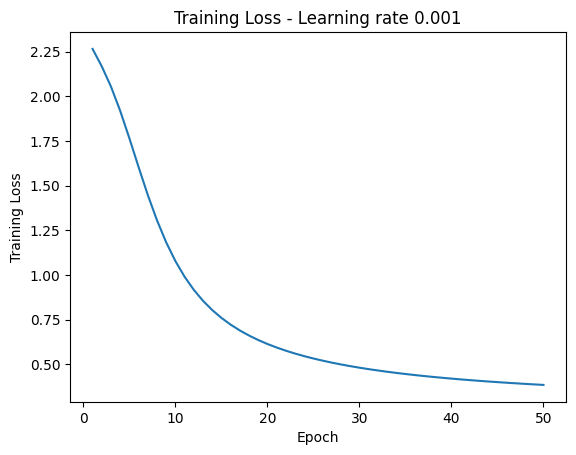

In [11]:
learning_rate = 0.001
epochs = 50

# Instatiating the base classifier and the Stochastic GD
mlp_seq_classifier = MLP_Classifier_Seq()
sgd_optimizer = torch.optim.SGD(mlp_seq_classifier.parameters(), 
                                lr=learning_rate)

# Training the model instantiated above
train(classifier = mlp_seq_classifier, optimizer = sgd_optimizer, epochs = epochs,
      X_train = training_set_batches, y_train = training_labels_batches)

As we would expect, the loss is decreasing as we execute each of the training iterations. Although this depends on the learning rate, the batch size and the training data, among others, this downward trend is expected. Let's test the model with unseen examples and measure the accuracy:

In [12]:
# Testing the model with unseen examples
final_loss, final_accuracy = test(classifier = mlp_seq_classifier,
                                  X_test = testing_set_batches, 
                                  y_test = testing_labels_batches,
                                  batch_size = batch_size)

Test loss: 0.006050375733040035, test accuracy: 89.38899230957031


We can see thatthe model has an accuracy of around 90%; this means that out of the ~30,000 observations in the testing set, the model is able to identify around 27,000 correctly. This will be our baseline accuracy when building CNN models.

### Building our First Convolutional Neural Network (CNN)

It is time to implement our own Convolutional Neural Network! To do so, we will start adding convolutional layers with activation functions one by one. First, we will grab some dummy samples taken from the training set to explain the application of the layers defined:

In [13]:
sample_array = torch.tensor(training_set_batches[0]).float()  # Grabbing the first batch of samples in the training set
sample_array.shape

torch.Size([64, 1, 28, 28])

The sample data has 64 observations of 28x28 images. Let's start by analyzing the first layer we will be adding, a convolutional layer with 32 output channels (neurons) produced:

In [14]:
seq_block_opt1_1 = nn.Sequential(   
    nn.Conv2d(1, 32, 3, 1),                                 # Convolutional layer with no padding
)

print('Block 1.1 -', seq_block_opt1_1(sample_array).shape)  # Printing the final size of the output

Block 1.1 - torch.Size([64, 32, 26, 26])


This single layer has a kernel of size (3, 3) and a stride of 1 without any padding. Hence, if the images have a size of (28, 28), the output will be having a size of (26, 26), since the kernel will decrease 2 units the width and the hight due to impossibility of executing the kernel over the pixels located in the borders.

If we want to add a padding, then we just need to make the parameter explicit during the definition:

In [15]:
seq_block_opt1_2 = nn.Sequential(
    nn.Conv2d(1, 32, 3, 1, padding='same'),                   # Convolutional layer with padding
)

print('Block 1.2 -', seq_block_opt1_2(sample_array).shape)    # Printing the final size of the output

Block 1.2 - torch.Size([64, 32, 28, 28])


Besides the padding argument that we have added, we can see that the output is having a size of (28,28) instead of (26,26), due to the inclusion of the padding! We will not use padding for our first CNN architecture, but will add a ReLU activation function:

In [16]:
seq_block_opt2 = nn.Sequential(
    nn.Conv2d(1, 32, 3, 1),                             # Convolutional layer with no padding
    nn.ReLU(inplace=True),                              # ReLU activation function applied sequentially
)

print('Block 2 -', seq_block_opt2(sample_array).shape)  # Printing the final size of the output

Block 2 - torch.Size([64, 32, 26, 26])


ReLU activation function should not change the output size expected, since it is applied over all the neurons built so far. Now, let's include a second convolutional layer, receiving 32 neurons and having 64 neurons in the output, with a kernel of size (3,3) and no padding:

In [17]:
seq_block_opt3 = nn.Sequential(
    nn.Conv2d(1, 32, 3, 1),                             # First Convolutional layer with no padding
    nn.ReLU(inplace=True),                              # ReLU activation function applied sequentially
    nn.Conv2d(32, 64, 3, 1),                            # Second Convolutional layer with no padding
)

print('Block 3 -', seq_block_opt3(sample_array).shape)  # Printing the final size of the output

Block 3 - torch.Size([64, 64, 24, 24])


Now, we have 64 neurons in the output per pixel, and (24,24) resulting values from both convolutions. This is due to the absence of a padding; since the second convolution was applied over matrices of size (26,26) with no padding, the result will be of size (24,24). Finally, we can add a second activation function:

In [18]:
seq_block_opt4 = nn.Sequential(
    nn.Conv2d(1, 32, 3, 1),                             # First Convolutional layer with no padding
    nn.ReLU(inplace=True),                              # First ReLU activation function applied sequentially
    nn.Conv2d(32, 64, 3, 1),                            # Second Convolutional layer with no padding
    nn.ReLU(inplace=True),                              # Second ReLU activation function applied sequentially
)

print('Block 4 -', seq_block_opt4(sample_array).shape)  # Printing the final size of the output

Block 4 - torch.Size([64, 64, 24, 24])


This is our first convolutional block, having two convolutional layers and two activation functions. The final number of neurons in the output of this block will be 64 * 24 * 24 = 36,864. The second portion of the CNN is a FFNN-based architecture that can include the following block:

In [19]:
ffnn_block = nn.Sequential(
    nn.Flatten(),             # Flattening the input to a single row
    nn.Linear(36864, 128),    # First linear layer of the FFNN portion
    nn.ReLU(inplace=True),    # ReLU activation function applied sequentially
    nn.Linear(128,10),        # Second linear layer of the FFNN portion
)

You can see that we are matching the number of neurons in the input of this later block, with the number of outputs of the former block when defining the CNN layers (36,864 neurons), and the number of classes that we have (10 digits). Let's put everything together to conform our first CNN architecture:

In [20]:
class CNN_Plain(nn.Module):
    def __init__(self):
        super(CNN_Plain, self).__init__()

        # Convolutional block
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),         # First Convolutional layer with no padding
            nn.ReLU(inplace=True),          # First ReLU activation function applied sequentially
            nn.Conv2d(32, 64, 3, 1),        # Second Convolutional layer with no padding
            nn.ReLU(inplace=True),          # Second ReLU activation function applied sequentially
        )

        # FFNN block
        self.block2 = nn.Sequential(
            nn.Flatten(),                   # Flattening the input to a single row
            nn.Linear(36864, 128),          # First linear layer of the FFNN portion
            nn.ReLU(inplace=True),          # ReLU activation function applied sequentially
            nn.Linear(128,10),              # Second linear layer of the FFNN portion
        )
    
    def forward(self, x):                   # Foward method to propagate information
        x = self.block1(x)
        return self.block2(x)

After defining our CNN architecture in `CNN_Plain`, we are ready to train the model:

Epoch: 1, Train loss: 2.1790275805032073
Epoch: 2, Train loss: 1.312905076597291
Epoch: 3, Train loss: 0.5634769140911509
Epoch: 4, Train loss: 0.4210257286201916
Epoch: 5, Train loss: 0.37475735171517327
Epoch: 6, Train loss: 0.3491959523862359
Epoch: 7, Train loss: 0.3310156316518275
Epoch: 8, Train loss: 0.31672179419348745
Epoch: 9, Train loss: 0.3046003618696605
Epoch: 10, Train loss: 0.29385553533906367
Epoch: 11, Train loss: 0.2839885603136091
Epoch: 12, Train loss: 0.2745107384617013
Epoch: 13, Train loss: 0.265205946248541
Epoch: 14, Train loss: 0.25617244294775066
Epoch: 15, Train loss: 0.2472375801710813
Epoch: 16, Train loss: 0.2385775832129694
Epoch: 17, Train loss: 0.23026390759739032
Epoch: 18, Train loss: 0.22239879706997606
Epoch: 19, Train loss: 0.2149094901740678
Epoch: 20, Train loss: 0.2076994394109066


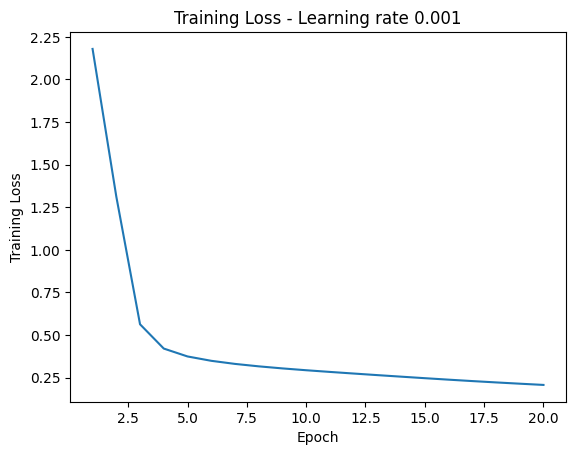

In [21]:
learning_rate = 0.001
epochs = 20

# Instatiating the base classifier and the Stochastic GD
cnn_plain_classifier = CNN_Plain()
sgd_optimizer = torch.optim.SGD(cnn_plain_classifier.parameters(), 
                                lr=learning_rate)

# Training the model instantiated above
train(classifier = cnn_plain_classifier, optimizer = sgd_optimizer, epochs = epochs,
      X_train = training_set_batches, y_train = training_labels_batches)

We can see that the loss is decreasing, as expected. Let's test the model with unseen examples and measure the accuracy:

In [22]:
# Testing the model with unseen examples
final_loss, final_accuracy = test(classifier = cnn_plain_classifier,
                                  X_test = testing_set_batches, 
                                  y_test = testing_labels_batches,
                                  batch_size = batch_size)

Test loss: 0.0032716501496239765, test accuracy: 93.97987365722656


The CNN model we just built is performing better than the FFNN, having an accuracy of almost 94% for the given classification task. However, we are including more than 36 thousand input neurons and the optimization is taking some time to complete. Let's reduce the number of neurons going through the final FFNN step of our CNN architecture by including a Max Pooling layer:

In [23]:
class CNN_Pooling(nn.Module):
    def __init__(self):
        super(CNN_Pooling, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),              # Max Pooling layer added to the CNN architecture
        )
        self.block2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(9216, 128),         # Linear layer changing input size from 36,864 neurons to 9,216
            nn.ReLU(inplace=True),
            nn.Linear(128,10),
        )

    def forward(self, x):
        x = self.block1(x)
        return self.block2(x)

This new architecture has two main changes:
- We included the Max Pooling layer at the end of the convolutional block. This will reduce the dimensionality of the output to one fourth, since the Max Pooling kernel has a size of (2,2) and no overlapping.
- The number of neurons in the input of the second block, the FFNN one, is, as stated above, one fourth of the original one. This means we are reducing dimensionality from 36,864 to 9,216, which will boost the training process and avoid overfitting.

Let's train the CNN model with Max Pooling:

Epoch: 1, Train loss: 2.2654730343361145
Epoch: 2, Train loss: 2.118377643353395
Epoch: 3, Train loss: 1.6158121201529432
Epoch: 4, Train loss: 0.8491581282508907
Epoch: 5, Train loss: 0.5456358325252655
Epoch: 6, Train loss: 0.4455220715196402
Epoch: 7, Train loss: 0.39806798376889624
Epoch: 8, Train loss: 0.369859349530643
Epoch: 9, Train loss: 0.35032563469112554
Epoch: 10, Train loss: 0.3354371114453273
Epoch: 11, Train loss: 0.3232554686285539
Epoch: 12, Train loss: 0.3128109032760805
Epoch: 13, Train loss: 0.30359230574959123
Epoch: 14, Train loss: 0.29519725250981765
Epoch: 15, Train loss: 0.28736727902375814
Epoch: 16, Train loss: 0.27990701915358684
Epoch: 17, Train loss: 0.27277149110714766
Epoch: 18, Train loss: 0.26595307749185737
Epoch: 19, Train loss: 0.25939644945423995
Epoch: 20, Train loss: 0.25308150416021663


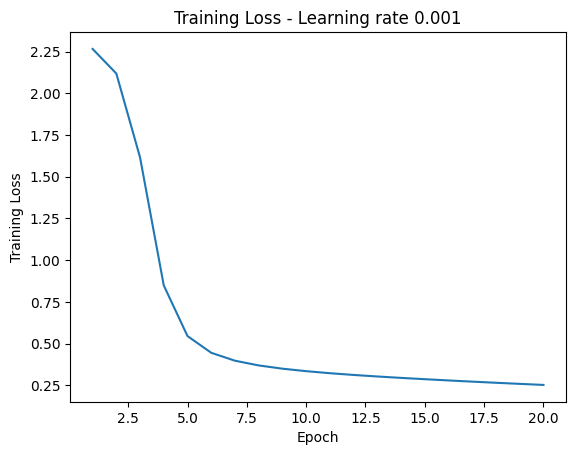

In [24]:
learning_rate = 0.001
epochs = 20

# Instatiating the base classifier and the Stochastic GD
cnn_pooling_classifier = CNN_Pooling()
sgd_optimizer = torch.optim.SGD(cnn_pooling_classifier.parameters(), 
                                lr=learning_rate)

# Training the model instantiated above
train(classifier = cnn_pooling_classifier, optimizer = sgd_optimizer, epochs = epochs,
      X_train = training_set_batches, y_train = training_labels_batches)

And the testing performance is:

In [25]:
# Testing the model with unseen examples
final_loss, final_accuracy = test(classifier = cnn_pooling_classifier,
                                  X_test = testing_set_batches, 
                                  y_test = testing_labels_batches,
                                  batch_size = batch_size)

Test loss: 0.003986810061977362, test accuracy: 92.59062194824219


By reducing the number of input neurons, we reduce the time it takes to train the model and the performance is still above 90%! To keep regularizing the network, we can add Batch Normalization layers in the convolutional and FFNN blocks:

In [26]:
class CNN_BatchNorm(nn.Module):
    def __init__(self):
        super(CNN_BatchNorm, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.BatchNorm2d(32),         # Two-dimensional Batch Normalization layer
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1),
            nn.BatchNorm2d(64),         # Two-dimensional Batch Normalization layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.block2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(9216, 128),
            nn.BatchNorm1d(128),        # One-dimensional Batch Normalization layer
            nn.ReLU(inplace=True),
            nn.Linear(128,10),
            nn.BatchNorm1d(10)          # One-dimensional Normalization layer
        )

    def forward(self, x):
        x = self.block1(x)
        return self.block2(x)

This new architecture has one main changes, we included Batch Normalization after all layers, with the corresponding size of their outputs. Let's train the CNN model with Batch Normalization:

Epoch: 1, Train loss: 0.6834748851846276
Epoch: 2, Train loss: 0.5011698810784802
Epoch: 3, Train loss: 0.4404020438443369
Epoch: 4, Train loss: 0.39802797561261194
Epoch: 5, Train loss: 0.3646915782489248
Epoch: 6, Train loss: 0.3370087592522981
Epoch: 7, Train loss: 0.3133315837014713
Epoch: 8, Train loss: 0.29274057439649537
Epoch: 9, Train loss: 0.2745667134584394
Epoch: 10, Train loss: 0.258364516534785
Epoch: 11, Train loss: 0.24380705745489611
Epoch: 12, Train loss: 0.23063363423988
Epoch: 13, Train loss: 0.2186395650161609
Epoch: 14, Train loss: 0.2076959055878206
Epoch: 15, Train loss: 0.19764128711813295
Epoch: 16, Train loss: 0.18839169091888583
Epoch: 17, Train loss: 0.17985034293965743
Epoch: 18, Train loss: 0.1719388083449559
Epoch: 19, Train loss: 0.1645974550070539
Epoch: 20, Train loss: 0.1577699469096625


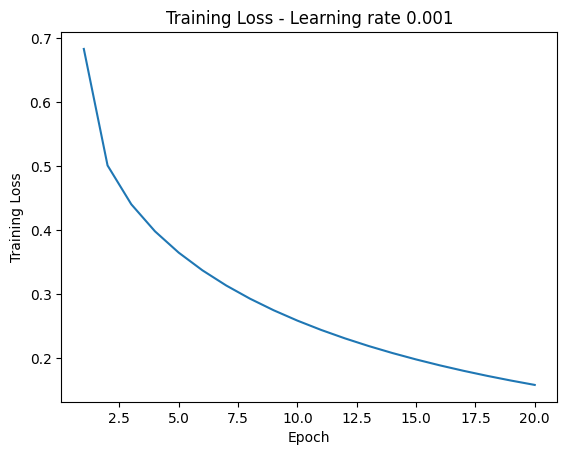

In [27]:
learning_rate = 0.001
epochs = 20

# Instatiating the base classifier and the Stochastic GD
cnn_batch_norm_classifier = CNN_BatchNorm()
sgd_optimizer = torch.optim.SGD(cnn_batch_norm_classifier.parameters(), 
                                lr=learning_rate)

# Training the model instantiated above
train(classifier = cnn_batch_norm_classifier, optimizer = sgd_optimizer, epochs = epochs,
      X_train = training_set_batches, y_train = training_labels_batches)

And the testing performance is:

In [28]:
# Testing the model with unseen examples
final_loss, final_accuracy = test(classifier = cnn_batch_norm_classifier,
                                  X_test = testing_set_batches, 
                                  y_test = testing_labels_batches,
                                  batch_size = batch_size)

Test loss: 0.0019640545092666074, test accuracy: 99.63352966308594


Finally, after including Batch Normalization, we can include a secondary regularization procedure, the Dropout, to ease the training process and reduce the likelihood of overfitting. We will include Dropout in both blocks, the CNN and the FFNN ones:

In [29]:
class CNN_Dropout(nn.Module):
    def __init__(self):
        super(CNN_Dropout, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),      # Dropout layer in the Convolutional block
        )
        self.block2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(9216, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),       # Dropout layer in the FFNN block
            nn.Linear(128,10),
            nn.BatchNorm1d(10)
        )

    def forward(self, x):
        x = self.block1(x)
        return self.block2(x)

This new and final architecture has one main changes, the inclusion of Dropout layers for CNN and FFNN blocks. Let's train the CNN model with Dropout:

Epoch: 1, Train loss: 1.0688524045415524
Epoch: 2, Train loss: 0.7956943750889824
Epoch: 3, Train loss: 0.70447465529574
Epoch: 4, Train loss: 0.6416893007277426
Epoch: 5, Train loss: 0.5975622590035518
Epoch: 6, Train loss: 0.5556466649971536
Epoch: 7, Train loss: 0.523204555961369
Epoch: 8, Train loss: 0.49577169123488957
Epoch: 9, Train loss: 0.47141785744919196
Epoch: 10, Train loss: 0.44931941646248547
Epoch: 11, Train loss: 0.4322715442953333
Epoch: 12, Train loss: 0.413452492848134
Epoch: 13, Train loss: 0.39774962357366517
Epoch: 14, Train loss: 0.3839825545229129
Epoch: 15, Train loss: 0.3710784935620802
Epoch: 16, Train loss: 0.35755894233041735
Epoch: 17, Train loss: 0.34634204898307575
Epoch: 18, Train loss: 0.33646350098190025
Epoch: 19, Train loss: 0.3278507924537415
Epoch: 20, Train loss: 0.3168014250457414


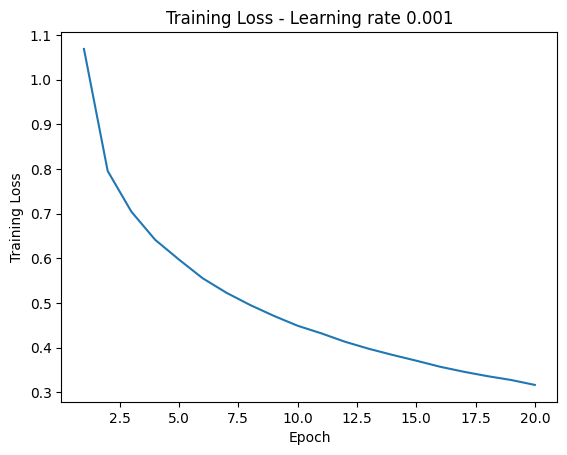

In [30]:
learning_rate = 0.001
epochs = 20

# Instatiating the base classifier and the Stochastic GD
cnn_dropout_classifier = CNN_Dropout()
sgd_optimizer = torch.optim.SGD(cnn_dropout_classifier.parameters(), 
                                lr=learning_rate)

# Training the model instantiated above
train(classifier = cnn_dropout_classifier, optimizer = sgd_optimizer, epochs = epochs,
      X_train = training_set_batches, y_train = training_labels_batches)

And the testing performance is:

In [31]:
# Testing the model with unseen examples
final_loss, final_accuracy = test(classifier = cnn_dropout_classifier,
                                  X_test = testing_set_batches, 
                                  y_test = testing_labels_batches,
                                  batch_size = batch_size)

Test loss: 0.003145770731765324, test accuracy: 98.25093078613281


After these model architecture changes, we can see that the models' testing performances are:

| Model                                                                           | Accuracy   | Training time |
|---------------------------------------------------------------------------------|------------|---------------|
| Multi-Layer perceptron                                                          | Around 89% | 8 seconds     |
| Plain CNN with two convolutional layers                                         | Around 93% | 240 seconds   |
| CNN with two convolutional layers and Max Pooling                               | Around 92% | 210 seconds   |
| CNN with two convolutional layers, Max Pooling and Batch Normalization          | Around 99% | 270 seconds   |
| CNN with two convolutional layers, Max Pooling, Batch Normalization and Dropout | Around 98% | 280 seconds   |

The model to be selected is the one having regularization and the best balance between training time complexity and accuracy; in this case is the `CNN_BatchNorm model` architecture, a CNN with two convolutional layers, Max Pooling and Batch Normalization. The model outperforms the Multi-Layer Perceptron by 11% using the same testing set, but is 34x more expensive to train (in time). The CNN model takes close to 5 minutes to be trained and identifies more than 29,700 digit images correctly out of ~30,000 images in the testing set (less than 300 incorectly classified). 

Let's see some of these correct and incorrect classifications.

### Zoom-in into some interesting testing examples

In the next code sections, we will see some cases where the model:
1. Classifies the data correctly and with high certainty
2. Classifies the data correctly, but with some uncertainty
3. Classifies the data incorrectly being uncertain about the output
4. Classifies the data incorrectly being certain about the output

In [32]:
# Testing method to facilitate the testing procedure
def test_and_plot(model, testing_sample, testing_label):
    target = torch.tensor(testing_label).long()                    # Parsing the labels to a tensor
    data = torch.tensor(testing_sample).float()                    # Converting the data into a Float tensor
    output = model(data)                                           # Calculating the output of the CNN for a given batch
    probas = torch.nn.functional.softmax(output[0], dim=0)         # Getting the predicted likelihood using the softmax function
    
    print('Real value is', target.item())                          # Printing the real value
    print('Predicted value is {} with {}% probability'.format(     # Printing the predicted value and the likelihood
        probas.argmax().item(), 
        int((probas.max()*100).round().item())))

    # Plotting the real image at the left and the model probabilities for all output neurons at the right
    fig, axes = plt.subplots(1,2,figsize=(12,3))       
    axes[0].imshow(testing_sample[0][0])            # Ploting the real testing image
    axes[0].axis('off')
    axes[1].bar(labels_input,                       # Plotting the model probabilities for all output neurons
            probas.detach().numpy())
    axes[1].set_xticks(range(0,10))
    plt.show() 

---- Example: The CNN model is correct and absolutely sure of the output ----
Real value is 5
Predicted value is 5 with 96% probability


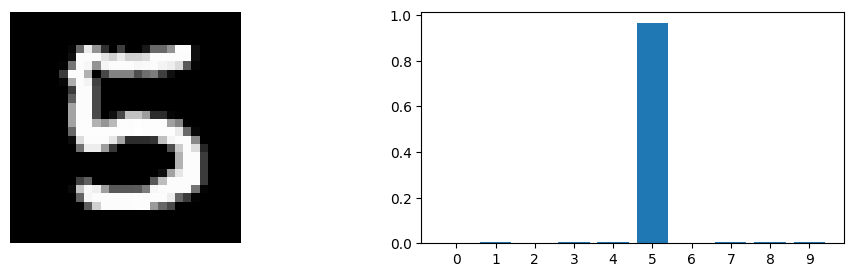

---- Example: The CNN model is correct, but unsure about the output ----
Real value is 1
Predicted value is 1 with 37% probability


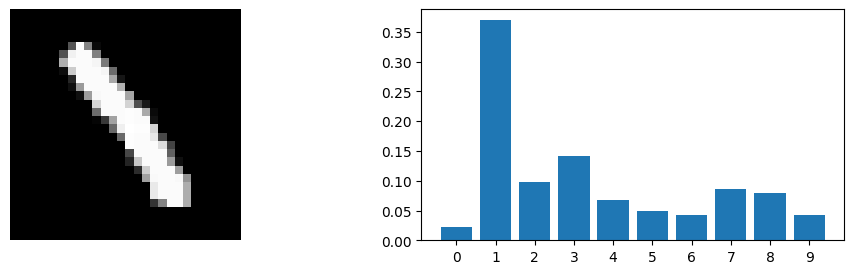

---- Example: The CNN model is wrong and unsure about the output ----
Real value is 9
Predicted value is 8 with 33% probability


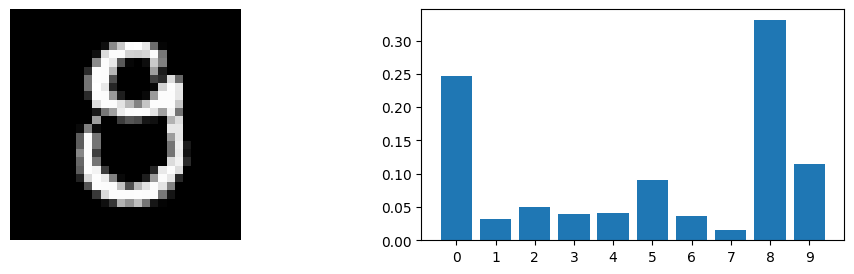

---- Example: The CNN model is wrong and sure about the output ----
Real value is 9
Predicted value is 7 with 69% probability


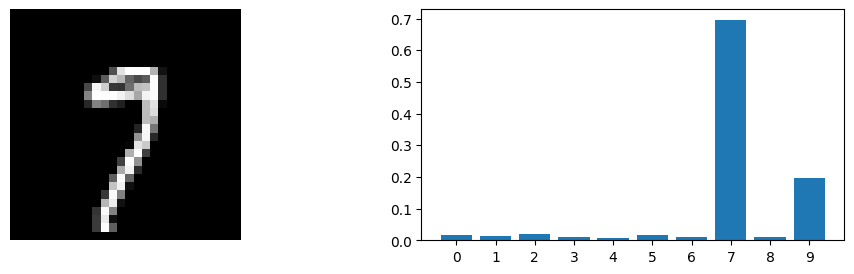

In [33]:
#   Dictionary of IDs according to the casses mapped above. The keys refer to (batch id, sample id in the batch)
## (5, 12)  -> The classifier is correct and absolutely sure of the output
## (2, 0)   -> The classifier is correct, but unsure about the output
## (0, 30)  -> The classifier is wrong and unsure about the output
## (85, 40) -> The classifier is wrong and sure about the output

idxs = {(5, 12):  'The CNN model is correct and absolutely sure of the output',
        (2, 0):   'The CNN model is correct, but unsure about the output',
        (0, 30):  'The CNN model is wrong and unsure about the output',
        (85, 40): 'The CNN model is wrong and sure about the output'}

for idx in idxs:
    print('---- Example:', idxs[idx], '----')
    test_and_plot(model = cnn_batch_norm_classifier, 
                  testing_sample = np.array([testing_set_batches[idx[0]][idx[1]]]), 
                  testing_label = testing_labels_batches[idx[0]][idx[1]])

From the results above, we can see that, altough the model has a high accuracy for the testing samples, there are some observations with which the model is struggling with, such as the last two. The model might be unsure of the output and struggle to identify the targets (case 3), or it can even be very sure about the output and get the target wrong (this happens for less than 5 testing observations, so the percentage might be negligible - 0.017%).

## Lessons learned

We learned:
- How implement a different architectures of a Convolutional Neural Network (CNN) from scratch using PyTorch, adding input, hidden and output layers with various dimensions, and read image data to be used in later processing.
- How to transform the images into processable data that a CNN can intake to generate meaningful outputs.
- How to add Pooling layers to reduce dimensionality of the features generated by convolutional layers.
- How to configure regularization layers and mix them up with convolutional and linear layers, such as adding Batch Normalization and Dropout.